# Annual Sea Level Rankings

```{glue:figure} SL_rankings
:align: center
```
In this notebook, we'll be creating a [table](SL_rankings_results), a [map](SL_rankings_map), and a time series [plot](SL_rankings_timeseries) of sea level rankings at Hawaiian Islands tide gauge stations from 1993-2024. Looking at extreme sea levels by ranking our top events helps us quickly put high and low water levels into historical context with relatively little coding effort. These top 10 events will later be put into a projection context using extreme value analyses (see the [non-stationary GEV](notebooks/nonstationaryGEV/monthly_extremes_non-stationaryGEV.ipynb) notebook), which will tell us how our historical events compare to, say, a 1-year, 10-year or 20-year return level. We'll also explore the reasons behind these unusually high or low events by examining how different processes contributed over various timescales in the [components](notebooks/components.ipynb) notebook. One interesting thing you might note, in the following exploration, is that the above plot (of Midway) shows that high events tend to somewhat evenly spread out through time. Compare this plot to other stations in the main Hawaiian Islands (jump to "show code cell output" in [Static Plots](static_plots)), and you'll find that these events tend to "cluster" more in time, as noted by {cite:t}`thompson_statistical_2019`.

Download Files:
[Map](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_rankings_map.png) |
[Time Series Plot](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_rankings_Nawiliwili.png) |
[Table](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_top_10_table_Nawiliwili.png)

## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called [setup](notebooks/setup.ipynb) and import our plotting functions, which will also set our data and output paths. If you have not run the [datawrangling notebook](notebooks/SL_Data_Wrangling.ipynb), you will need to do this before running this notebook. Note that this notebook is also largely a repeat of the [anomaly](notebooks/regional_and_local/SL_anomaly_annual.ipynb) notebook. 

In [1]:
%run ../setup.ipynb

import plotly.io as pio

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii.nc').exists():
    print('rsl_hawaii.nc not found in '+ str(data_dir) +  '. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in '+ str(data_dir) +  '. Proceed.')

rsl_hawaii.nc found in /Users/jfiedler/Documents/SL_Hawaii_data/data. Proceed.


### Import data and Clean
Take only locations with data coverage more than 80% of the time, and set all sea level measurements relative to local MHHW, rather than station datum.

In [2]:
#import rsl_daily
with xr.open_dataset(data_dir/ 'rsl_hawaii_noaa.nc') as ds:
    rsl_daily = ds.sel(time=slice('1993','2024'))

    data_coverage = rsl_daily['sea_level'].count(dim='time')/len(rsl_daily.time)

    data_coverage
    #drop all locations with data_coverage less than 80%
    rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

# make sea level relative to MHHW, and ensure units are in meters
rsl_subset['sea_level'] = rsl_subset['sea_level'] - rsl_subset['MHHW']

# check units in attrs of ds['sea_level'], if in mm make into m. If in m, leave in meters.
if ds['sea_level'].attrs['units'] == 'mm':
    rsl_subset['sea_level'] = rsl_subset['sea_level']/1000
elif ds['sea_level'].attrs['units'] == 'm':
    pass

rsl_subset['sea_level'].attrs['units'] = 'm'

# rename variable long name to sea level relative to MHHW
rsl_subset['sea_level'].attrs['long_name'] = 'sea level, MHHW'


Let's make a nice little dictionary to contain our station name to station ID matching.

In [3]:
# Create a mapping from station name to station_id
station_map = dict(zip(rsl_subset['station_name'].values, rsl_subset['station_id'].values.astype(str)))


### Resample to monthly
For background plotting purposes. Here we'll extract the mean, min and max of the monthly MHHW sea level.

In [4]:
# get min and max for each month by resampling
rsl_monthly_min = rsl_subset.resample(time='1ME').min()
rsl_monthly_max = rsl_subset.resample(time='1ME').max()
rsl_monthly_mean = rsl_subset.resample(time='1ME').mean()

### Define functions
The first will get us the top 10 high and low hourly sea level values for a given station. To ensure that we are tracking unique high and low water events, we ensure that the hourly maxima and minima are separated by at least 3 days.

In [5]:
def get_top_ten(rsl_subset, station_id, mode='max'):
    # Convert data to a pandas Series
    sea_level_series = rsl_subset.sea_level.sel(station_id=station_id).to_series()

   # Select top 100 values based on the mode
    if mode == 'max':
        top_values = sea_level_series.nlargest(100)
    elif mode == 'min':
        top_values = sea_level_series.nsmallest(100)
    else:
        raise ValueError('mode must be either "max" or "min"')

    # Filter to find unique events spaced by at least 3 days
    filtered_dates = []
    top_10_values = pd.Series()

    for date, value in top_values.items():
        if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
            filtered_dates.append(date)
            top_10_values[date] = value
        if len(filtered_dates) == 10:
            break
    rank = np.arange(1,11)

    station_name = str(rsl_subset['station_name'].sel(station_id=str(station_id)).values)
    # station_name = str(rsl_subset['station_name'].isel(station_id=station_id).values)
    # station_id = rsl_subset['station_id'].isel(station_id=station_id).values

    top_10_values = pd.DataFrame({'rank': rank, 'date': top_10_values.index, 'sea level (m)': top_10_values.values})  
    top_10_values['station_name'] = station_name
    top_10_values['station_id'] = station_id
    top_10_values['type'] = mode

    #round the date to the nearest hour
    top_10_values['date'] = top_10_values['date'].dt.round('h')

    return top_10_values

## Make a Table
We'll use the function we defined above to make a table of the top 10 ranked high and low water events. We'll add the ONI values to this table, which will come in handy later.

In [6]:
def get_top_10_table(rsl_subset,station_id):
    # make a table of the top 10 values, sorted by size and with date
    top_10_values_max = get_top_ten(rsl_subset, station_id, mode='max')
    top_10_values_min = get_top_ten(rsl_subset, station_id, mode='min')

    top_10_table = pd.concat([top_10_values_max,top_10_values_min])

    # cross reference the dates with the oni data to see if they are during an El Nino or La Nina event
    oni = pd.read_csv(data_dir / 'climate_indices' / 'oni.csv', index_col='time', parse_dates=True)

    # El Nino is true when ONI > 0.5 for 5 consecutive periods 
    oni['El Nino'] = (oni['ONI'] > 0.5).rolling(window=5).sum() == 5

    # La Nina is true when ONI < -0.5 for 5 consecutive periods 
    oni['La Nina'] = (oni['ONI'] < -0.5).rolling(window=5).sum() == 5

    # add a new column to oni_min called mode, where mode is either 'El Nino', 'La Nina', or 'Neutral'
    oni['ONI Mode'] = 'Neutral'
    oni.loc[oni['La Nina'] ==True, 'ONI Mode'] = 'La Nina'
    oni.loc[oni['El Nino'] ==True, 'ONI Mode'] = 'El Nino'

    #drop the La Nina and El Nino columns
    oni = oni.drop(columns=['La Nina', 'El Nino'])

    #Extract ONI values for the corresponding dates of top_10_table
    oni_val = oni.reindex(top_10_table['date'], method='nearest')
    
    # add the oni values to the top_10_table
    top_10_table = pd.merge(top_10_table, oni_val, left_on='date', right_index=True)

    return top_10_table

As a quick example, we can check the for the Honolulu. Note that because we started this analysis with hourly data, we may not be fully aligned with max/min statistics from other sources. Hourly data will dampen both the minima and maxima due to averaging. Note also that there are other extreme water level rankings that may be offset by a different MHHW datum. Here, we used the 1983-2001 NTDE that is currently available through NOAA CO-OPS. 

```{margin}
For other ranking tables, check out the [NASA Flooding Analysis Tool](https://sealevel.nasa.gov/flooding-analysis-tool/observed-flooding?station-id=1612340) or the [Sea Level Calculator](https://coast.noaa.gov/sealevelcalculator/#/quickview/1612340/extremeWaterLevels&search=eyJhY3RpdmVQYWdlIjoicXVpY2t2aWV3IiwidGlkZVN0YXRpb25JZCI6MTYxMjM0MCwic2VsZWN0ZWRRdWlja1ZpZXciOiJleHRyZW1lV2F0ZXJMZXZlbHMiLCJ0aGVtZSI6ImRhcmsiLCJpc1F1aWNrU2VsZWN0QWN0aXZlIjpmYWxzZSwibWFwTG9jYXRpb24iOnsiY2VudGVyIjpbLTE1Ny44NjQ1MjgsMjEuMzAzMzMyOTk5OTk5OTk1XSwiem9vbSI6MTEuNX0sImFkZHJlc3MiOiJIb25vbHVsdSwgSEkiLCJzdGF0aW9uSXNTZWxlY3RlZCI6dHJ1ZSwiZ2xvYmFsTWVudVZhbHVlcyI6eyJkYXR1bSI6Ik1ISFciLCJ1bml0cyI6ImVuZ2xpc2giLCJkZWNhZGUiOiIyMDMwIiwidmxtIjowLjAwNDMzMDcxMDk5OTk5OTk5OSwidGhyZXNob2xkIjowLjk5NywicHJlRGVmVGhyZXNob2xkIjp7ImxhYmVsIjoiTk9TIE1pbm9yIiwidmFsdWUiOnsiZW5nbGlzaCI6MC45OTcsIm1ldHJpYyI6MC4zMDR9LCJwYXJhbSI6Im5vc19taW5vciJ9LCJkYXlzVGhyZXNob2xkIjpudWxsLCJkYXRhU291cmNlIjoiMjAyMiBUZWNoIFJlcG9ydCIsIm9mZnNldFllYXIiOiIyMDAwIiwic2NlbmFyaW8iOiJJbnRlcm1lZGlhdGUiLCJtc2xUaHJlc2hvbGRJbk1ldHJpYyI6MC42MzMsImNvbnZlcnRlZFZMTSI6MC4xMDk5OTk5OTk5OTk5OTk5OX0sImN1cnJlbnRTdGF0aW9uUHJvcGVydGllcyI6eyJuYW1lIjoiSG9ub2x1bHUsIEhJIiwic3RhdGlvbklEIjoxNjEyMzQwLCJxdiI6WzEsMiwzLDQsNV0sInNsUHJvamVjdGlvblJlZ2lvbk5BU0EiOiJQQUMiLCJiZWdpbkRhdGUiOiIxOTExIiwiZW5kRGF0ZSI6bnVsbCwic3RhdGlvbkxvbiI6LTE1Ny44NjQ1MjgsInN0YXRpb25MYXQiOjIxLjMwMzMzM30sIm5vc1RocmVzaG9sZExheWVyIjoibm9zLW1pbm9yIiwid2F0ZXJMZXZlbCI6IjAiLCJpc01hcEZ1bGwiOmZhbHNlLCJncmlkRGF0YSI6eyJjZWxsRXh0ZW50IjpbXSwiY2xpY2tlZENvb3JkcyI6bnVsbCwiZ3JpZE51bWJlciI6bnVsbCwiUFNNU0xfSUQiOm51bGwsInJlZ2lvbiI6bnVsbH0sImlzU29sb0dyaWRDZWxsIjpmYWxzZSwicmV0cmlldmVkVkxNVmFsdWUiOjAuMTA5OTk5OTk5OTk5OTk5OTksImlzR3JpZExheWVyRGlzcGxheWVkIjp0cnVlLCJzZWxlY3RlZEJhc2VtYXAiOiJzYXRlbGxpdGUiLCJxdjFMZWdlbmQiOnsidGgiOjEsImgiOjEsImloIjoxLCJpIjoxLCJpbCI6MSwibCI6MSwib2UiOjEsInViIjowfSwicXYyTGVnZW5kIjp7ImFkYXQiOjEsImgiOjAsImloIjowLCJpIjowLCJpbCI6MCwibCI6MCwiZCI6MX0sInF2M0xlZ2VuZCI6eyJ0aCI6MSwibXdsIjoxLCJ0UGVyIjoxLCJ0ZW5QZXIiOjEsImZQZXIiOjEsIm5uUGVyIjoxfSwicXY0TGVnZW5kIjp7Im1tIjoxLCJldFBlciI6MSwic1BlciI6MSwibW8iOjEsInJvIjoxLCJsciI6MX0sInF2NUxlZ2VuZCI6eyJkdCI6MSwiZmQiOjEsIm12IjoxLCJhc2MiOjF9LCJxdjVDaGFydEJMZWdlbmQiOnsidHdvUCI6MSwidGVuUCI6MSwiZmlmUCI6MSwibmluUCI6MX19)
```

In [7]:
station_name = str(rsl_subset['station_name'].isel(station_id=6).values)
station_id = station_map[station_name]
top_10_table = get_top_10_table(rsl_subset, station_id)

station_name

'Nawiliwili'

### Display by rank
Now we'll start to make the table a little more presentable by labeling the columns properly, and organizing events by rank.

In [8]:
# subdivide the data into two columns for max and min
# Filter out the 'max' and 'min' types into separate DataFrames
max_top_10 = top_10_table[top_10_table['type'] == 'max'].reset_index(drop=True)
min_top_10 = top_10_table[top_10_table['type'] == 'min'].reset_index(drop=True)

# make table of highest and lowest values by rank, with columns: rank, highest sea level (m), date, lowest sea level (m), date
top_10_display = pd.DataFrame({'Rank':max_top_10['rank'],
                             'Highest':max_top_10['sea level (m)'].apply(lambda x: float(f"{x:.3g}")),
                             'Highest Date':max_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Highest ONI Mode':max_top_10['ONI Mode'],
                             'Lowest':min_top_10['sea level (m)'].apply(lambda x: float(f"{x:.3g}")),
                             'Lowest Date':min_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Lowest ONI Mode':min_top_10['ONI Mode'],
                             'Zone': 'GMT',
                             'ONI max':max_top_10['ONI'],
                             'ONI min':min_top_10['ONI']})

(SL_rankings_results)=
### Style the table
Now we'll add some style. The table will be colored by the ONI, if the event is classified as an El Nino or La Nina.

In [9]:
# # Define a function that returns styles for both 'Highest' and 'Lowest' based on respective ONI Modes
# # Normalize the ONI values
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=-3, vmax=3)

# Define the color maps
cmap = sns.color_palette('coolwarm', as_cmap=True)

def style_oni_based(row):
    styles = {}
    # Color for 'Highest' based on 'Highest ONI Mode'
    if row['Highest ONI Mode'] == 'El Nino':
        styles['Highest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI max"])))}'
    elif row['Highest ONI Mode'] == 'La Nina':
        styles['Highest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI min"])))}'
    else:
        styles['Highest'] = 'color: black'  # Neutral or undefined
    # Color for 'Lowest' based on 'Lowest ONI Mode'
    if row['Lowest ONI Mode'] == 'El Nino':
        styles['Lowest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI max"])))}'
    elif row['Lowest ONI Mode'] == 'La Nina':
        styles['Lowest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI min"])))}'
    else:
        styles['Lowest'] = 'color: black'  # Neutral or undefined
    return pd.Series(styles)    

# Define the table style
styles_col = [
    {'selector': 'th', 'props': [('border-bottom', '2px solid #000'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': '.dataframe th:nth-child(3)', 'props': [('padding-right', '100px')]}]

# Apply the styling function to the DataFrame
top_10_d = top_10_display.style.\
                            apply(style_oni_based, axis=1).\
                            hide(subset=['Highest ONI Mode', 'Lowest ONI Mode','ONI max','ONI min'], axis=1).\
                            hide().\
                            set_table_attributes(styles_col)


# Display the styled DataFrame



tablename = 'SL_top_10_table_' + station_name + '.csv'
# save table to output folder
top_10_display.to_csv(output_dir / tablename, index=False)

top_10_d

Rank,Highest,Highest Date,Lowest,Lowest Date,Zone
1,0.451000,2023-10-30 15:00,-0.871000,2011-03-12 00:00,GMT
2,0.425000,2022-01-15 12:00,-0.821000,2010-02-28 07:00,GMT
3,0.415000,2024-08-20 02:00,-0.813000,2010-03-05 22:00,GMT
4,0.409000,2024-11-16 14:00,-0.788000,2000-01-21 07:00,GMT
5,0.392000,2020-12-15 15:00,-0.784000,2002-02-27 07:00,GMT
6,0.390000,2017-07-23 02:00,-0.780000,1993-11-15 07:00,GMT
7,0.384000,2021-12-05 15:00,-0.780000,1994-02-06 03:00,GMT
8,0.378000,2023-08-30 01:00,-0.777000,1993-12-14 07:00,GMT
9,0.374000,2024-08-31 00:00,-0.776000,1994-02-03 00:00,GMT
10,0.373000,2016-06-05 02:00,-0.775000,1993-11-12 05:00,GMT


In [10]:
#make this a pretty table with great_tables
from great_tables import GT, md, html

# replace all spaces with underscores in top_10_display column names
top_10_display.columns = top_10_display.columns.str.replace(' ', '_')

outFilename = 'SL_top_10_table_' + station_name + '.png'
outFilepath = output_dir / outFilename

# Convert the DataFrame to a great_table
(
    GT(top_10_display)
    .tab_header(title='Top 10 Sea Level Events', subtitle='Station: '+station_name)
    .tab_spanner(label='HIGHEST', columns=['Highest', 'Highest_Date', 'Highest_ONI_Mode'])
    .tab_spanner(label='LOWEST', columns=['Lowest', 'Lowest_Date', 'Lowest_ONI_Mode'])
    .cols_hide(columns=['ONI_max','ONI_min','Zone'])
    .cols_align('center')
    .cols_label(Highest=html('Water Level <br>(m, MHHW)'), Highest_Date='Date', Highest_ONI_Mode='ONI Mode',
                Lowest=html('Water Level <br>(m, MHHW)'), Lowest_Date='Date', Lowest_ONI_Mode='ONI Mode')
                .tab_source_note(source_note='Source: NOAA CO-OPS Hourly Water Level, https://psl.noaa.gov/data/correlation/oni.data')
    .save(outFilepath)
)

GT(_tbl_data=   Rank  Highest      Highest_Date Highest_ONI_Mode  Lowest       Lowest_Date  \
0     1    0.451  2023-10-30 15:00          El Nino  -0.871  2011-03-12 00:00   
1     2    0.425  2022-01-15 12:00          La Nina  -0.821  2010-02-28 07:00   
2     3    0.415  2024-08-20 02:00          Neutral  -0.813  2010-03-05 22:00   
3     4    0.409  2024-11-16 14:00          Neutral  -0.788  2000-01-21 07:00   
4     5    0.392  2020-12-15 15:00          La Nina  -0.784  2002-02-27 07:00   
5     6    0.390  2017-07-23 02:00          Neutral  -0.780  1993-11-15 07:00   
6     7    0.384  2021-12-05 15:00          Neutral  -0.780  1994-02-06 03:00   
7     8    0.378  2023-08-30 01:00          Neutral  -0.777  1993-12-14 07:00   
8     9    0.374  2024-08-31 00:00          Neutral  -0.776  1994-02-03 00:00   
9    10    0.373  2016-06-05 02:00          Neutral  -0.775  1993-11-12 05:00   

  Lowest_ONI_Mode Zone  ONI_max  ONI_min  
0         La Nina  GMT     1.92    -0.93  
1         El Nino  GMT    -0.97     0.84  
2         El Nino  GMT    -0.21     0.84  
3         La Nina  GMT    -0.53    -1.41  
4         Neutral  GMT    -1.19     0.09  
5         Neutral  GMT    -0.11     0.04  
6         Neutral  GMT    -0.98     0.07  
7         Neutral  GMT     1.56     0.06  
8         Neutral  GMT    -0.21     0.07  
9         Neutral  GMT    -0.07     0.04  , _body=<great_tables._gt_data.Body object at 0x3012ef620>, _boxhead=Boxhead([ColInfo(var='Rank', type=<ColInfoTypeEnum.default: 1>, column_label='Rank', column_align='center', column_width=None), ColInfo(var='Highest', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Water Level <br>(m, MHHW)'), column_align='center', column_width=None), ColInfo(var='Highest_Date', type=<ColInfoTypeEnum.default: 1>, column_label='Date', column_align='center', column_width=None), ColInfo(var='Highest_ONI_Mode', type=<ColInfoTypeEnum.default: 1>, column_label='ONI Mode', column_align='center', column_width=None), ColInfo(var='Lowest', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Water Level <br>(m, MHHW)'), column_align='center', column_width=None), ColInfo(var='Lowest_Date', type=<ColInfoTypeEnum.default: 1>, column_label='Date', column_align='center', column_width=None), ColInfo(var='Lowest_ONI_Mode', type=<ColInfoTypeEnum.default: 1>, column_label='ONI Mode', column_align='center', column_width=None), ColInfo(var='Zone', type=<ColInfoTypeEnum.hidden: 4>, column_label='Zone', column_align='center', column_width=None), ColInfo(var='ONI_max', type=<ColInfoTypeEnum.hidden: 4>, column_label='ONI_max', column_align='center', column_width=None), ColInfo(var='ONI_min', type=<ColInfoTypeEnum.hidden: 4>, column_label='ONI_min', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x3012ef230>, _spanners=Spanners([SpannerInfo(spanner_id='HIGHEST', spanner_level=0, spanner_label='HIGHEST', spanner_units=None, spanner_pattern=None, vars=['Highest', 'Highest_Date', 'Highest_ONI_Mode'], built=None), SpannerInfo(spanner_id='LOWEST', spanner_level=0, spanner_label='LOWEST', spanner_units=None, spanner_pattern=None, vars=['Lowest', 'Lowest_Date', 'Lowest_ONI_Mode'], built=None)]), _heading=Heading(title='Top 10 Sea Level Events', subtitle='Station: Nawiliwili', preheader=None), _stubhead=None, _source_notes=['Source: NOAA CO-OPS Hourly Water Level, https://psl.noaa.gov/data/correlation/oni.data'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x3012efa10>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_rig

(SL_rankings_timeseries)=
## Make Timeseries Plots
Now we'll plot this data up in the time domain.

### Interactive Plots
This version is interactive. Bad for making pdf reports though.

In [11]:
import plotly.graph_objects as go

def make_plotlyFigure(rsl_monthly_mean, rsl_monthly_max, rsl_monthly_min, top_10_table, rsl_subset, station_id):
    figly = go.Figure()
    top_10_table = get_top_10_table(rsl_subset, station_id)
    x = rsl_monthly_mean.time - np.timedelta64(15, 'D')  # add 15 days to make the line in the middle of the month
    
    # Add traces
    figly.add_trace(go.Scatter(x=x, y=rsl_monthly_max['sea_level'].sel(station_id=station_id), mode='lines', line_color='rgba(0,176,246,0.2)', name='Monthly Max'))
    figly.add_trace(go.Scatter(x=x, y=rsl_monthly_min['sea_level'].sel(station_id=station_id), mode='lines', line_color='rgba(0,176,246,0.2)', fill='tonexty', fillcolor='rgba(0,176,246,0.2)', name='Range (Monthly Max/Min)'))
    figly.add_trace(go.Scatter(x=x, y=rsl_monthly_mean['sea_level'].sel(station_id=station_id), mode='lines', line_color='rgba(0,176,246,1)', name='Monthly Mean'))

    # Add El Niño markers
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='El Nino'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'],
                                mode='markers', marker=dict(color='red', size=12, symbol='star'), name='El Niño',
                                hoverinfo='none'))
    
    # Add La Niña markers
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='La Nina'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'],
                                mode='markers', marker=dict(color='blue', size=12, symbol='circle'), name='La Niña',
                                hoverinfo='none'))
    
    # Add highest/lowest events markers
    figly.add_trace(go.Scatter(x=top_10_table.date, y=top_10_table['sea level (m)'], 
                                mode='markers', marker=dict(color='orange', size=6, symbol='circle'), name='Highest/Lowest Events',
                                hovertemplate='%{x}, %{y:.2f} m<extra></extra>'))
    
    # Update layout
    figly.update_layout(
        title=str(station_name),
        xaxis_title='Time',
        yaxis_title=f"{rsl_subset['sea_level'].attrs['long_name']} [{rsl_subset['sea_level'].attrs['units']}]",
        showlegend=True,
        # width=500,  # Set figure width
        # height=400,  # Set figure height
        autosize=True,  # Turn off autosize
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)', range=['1993-01-01', '2024-12-31']),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)'),
        legend=dict(
            orientation='h',  # Horizontal orientation
            y=-0.3,  # Position below the plot
            x=0.5,  # Centered horizontally
            xanchor='center',
            yanchor='top',
            font=dict(size=10)  # Smaller font size for legend items
        ),
        margin=dict(l=50, r=50, t=50, b=100),  # Increase bottom margin to make room for the legend
        title_x=0.5,  # Center the title
        title_font_size=20,
        title_font_family='Arial',
        title_font_color='black'
    )


    
    # figly.show()
    return figly

A note: the plotly plot will not render in the jupyter book build, because the original data to build it is stored elsewhere (not on github). If you are replicating this notebook, it should work fine for you. In the meantime, the pre-built html is available.

In [12]:
figly = make_plotlyFigure(rsl_monthly_mean, 
        rsl_monthly_max, rsl_monthly_min, 
        top_10_table, rsl_subset,str(station_map[station_name]))

# change size of the plot
# figly.update_layout(autosize=True)
figly.update_layout(width=800, height=500,autosize=False)
# save the figure to the output folder
figname = 'SL_top_10_plot_' + station_name + '.html'

# remove commas from figname
figname = figname.replace(', ','_')
matrix_dir = Path('../../matrix/plotly')
pio.write_html(figly, str(matrix_dir / figname), auto_open=False)

figly

In [16]:
from IPython.display import IFrame
IFrame(src='https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/plotly/SL_top_10_plot_Nawiliwili.html', width=800, height=500, align='center')

```{note}
Note: If the rendering doesn't work here for the interactive plot: visit the [pre-made plot](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/plotly/SL_top_10_plot_Nawiliwili.html) to explore the data in more detail.
```

(static_plots)=
### Static Plots
Plotting them all so we can decide what to do with them. Click "show code cell output" to see all stations.

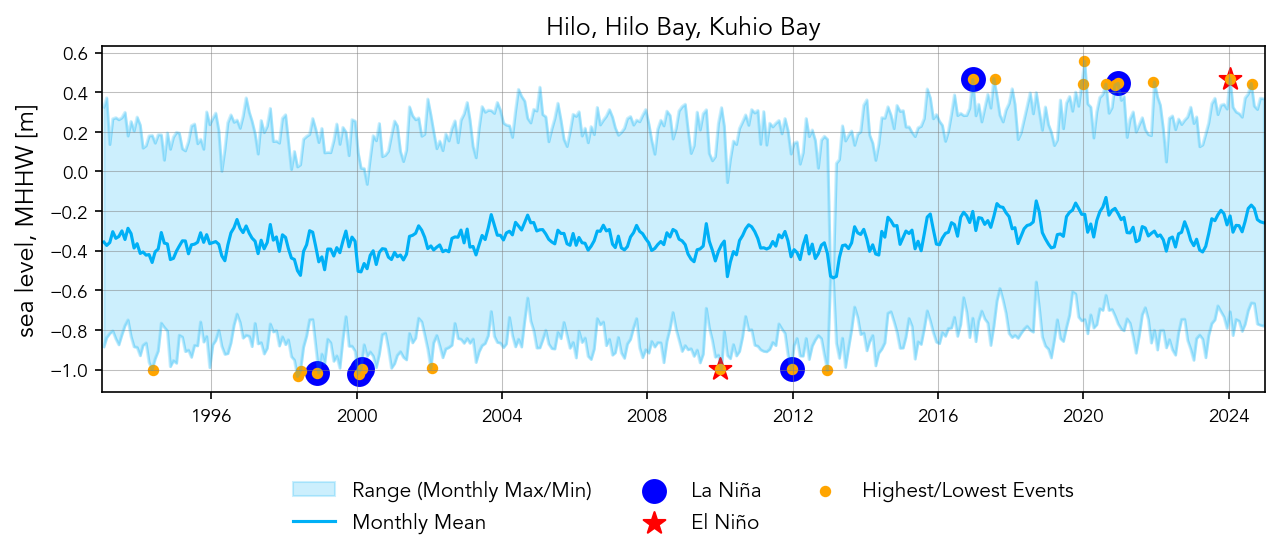

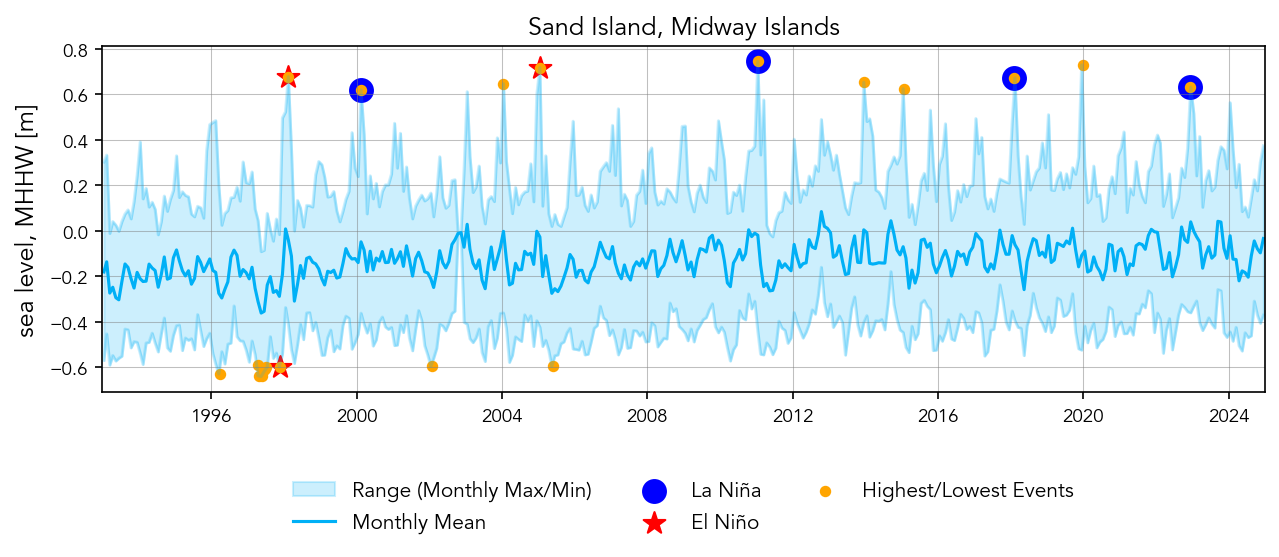

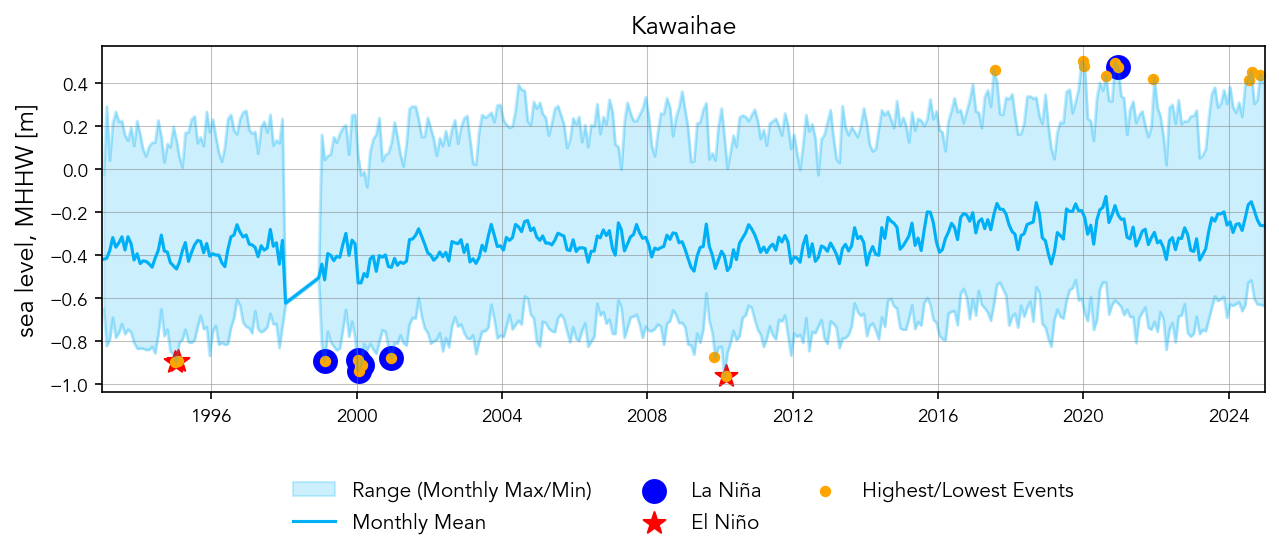

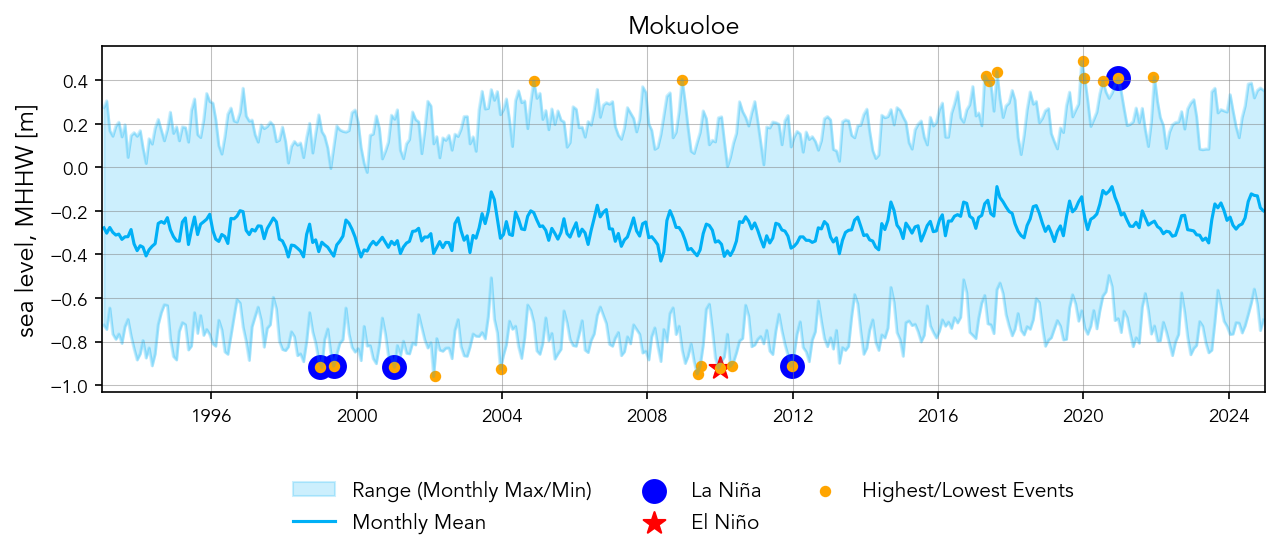

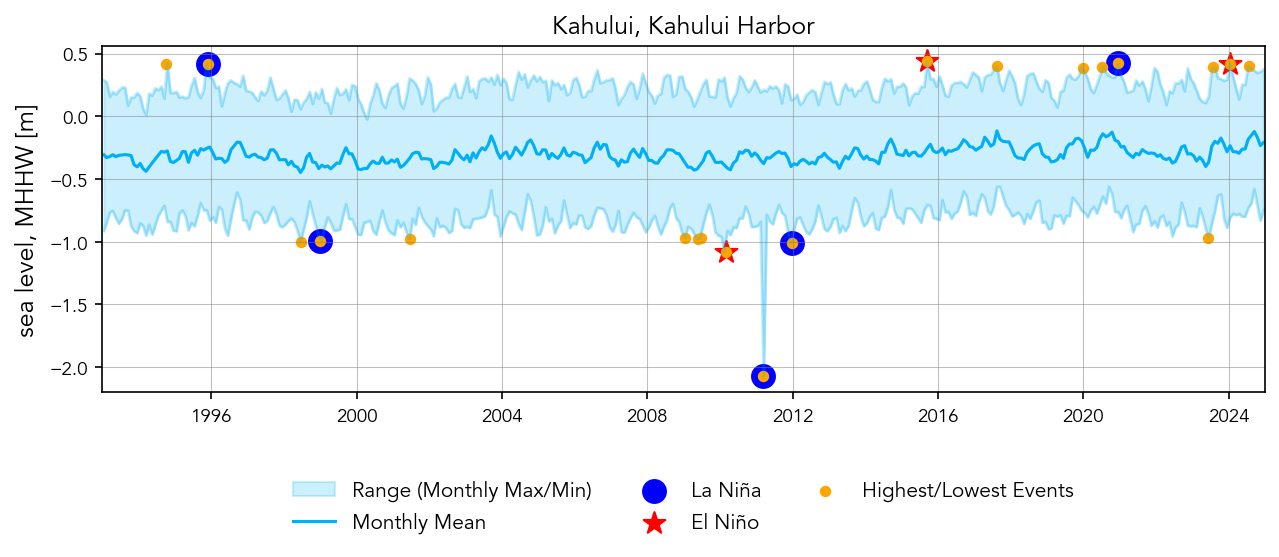

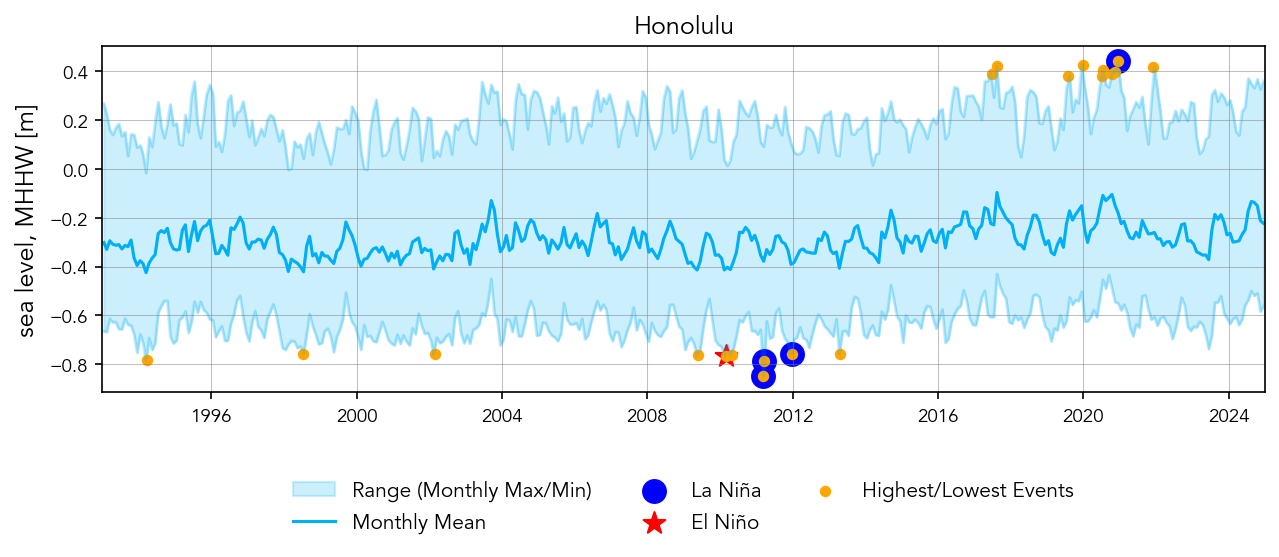

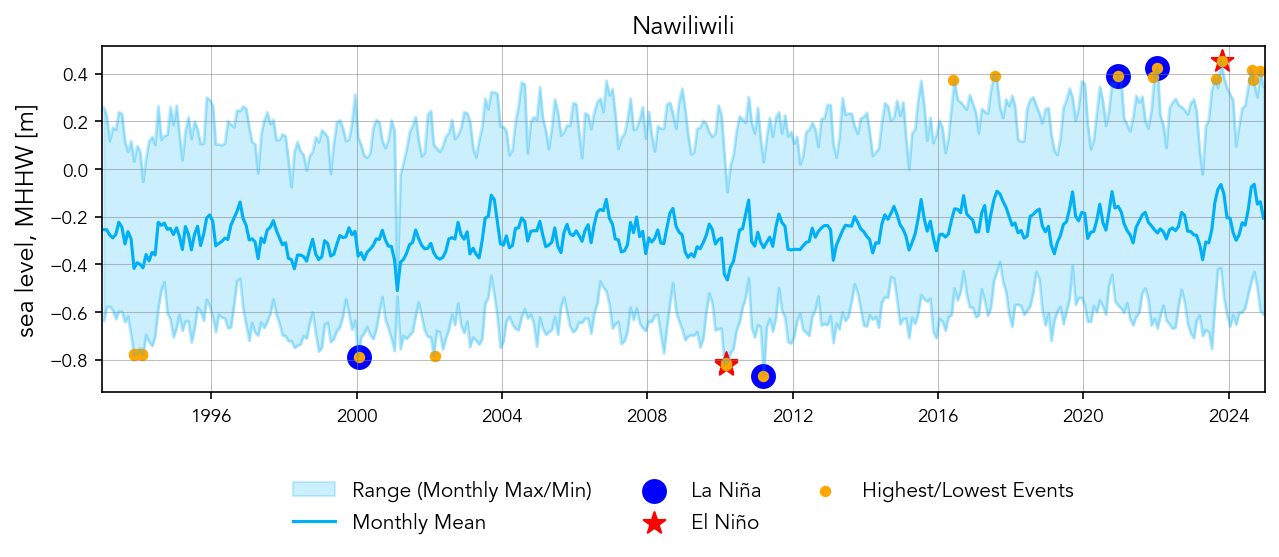

In [13]:
# static version

# Plot configuration

# loop through all the records
for i,station_name in enumerate(station_map):
    station_idx = i
    top_10_table = get_top_10_table(rsl_subset,station_map[station_name])
    # get top_10_table for each record
    station_id = station_map[station_name]
    fig,ax = plt.subplots(1,1,figsize=(10,3))

    x = rsl_monthly_mean.time - np.timedelta64(15,'D') # add 15 days to make the line in the middle of the month

    # station_name = str(rsl_subset['station_name'].sel(station_id=station_id).values)
    ax.set_title(station_name)
    ax.set_ylabel(f'{rsl_subset["sea_level"].attrs["long_name"]} [{rsl_subset["sea_level"].attrs["units"]}]')
    
    # Plot the max, min, and mean lines
    # Plot the max, min, and mean lines
    ax.plot(x, rsl_monthly_max['sea_level'].sel(station_id=station_id), color=(0/255, 176/255, 246/255, 0.2))
    ax.plot(x, rsl_monthly_min['sea_level'].sel(station_id=station_id), color=(0/255, 176/255, 246/255, 0.2))
    ax.fill_between(x, rsl_monthly_max['sea_level'].sel(station_id=station_id), 
                     rsl_monthly_min['sea_level'].sel(station_id=station_id), color=(0/255, 176/255, 246/255, 0.2), label='Range (Monthly Max/Min)')
    ax.plot(x, rsl_monthly_mean['sea_level'].sel(station_id=station_id), color=(0/255, 176/255, 246/255, 1), label='Monthly Mean')

    # Plot the markers for La Niña, El Niño, and other events
    ax.scatter(top_10_table[top_10_table['ONI Mode']=='La Nina'].date, top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'], color='blue', s=120, label='La Niña', marker='o')
    ax.scatter(top_10_table[top_10_table['ONI Mode']=='El Nino'].date, top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'], color='red', s=120, label='El Niño', marker='*')
    ax.scatter(top_10_table.date, top_10_table['sea level (m)'], color='orange', s=20, label='Highest/Lowest Events', marker='o')
    
    # Setting the x-axis limits
    ax.set_xlim(pd.Timestamp('1993-01-01'), pd.Timestamp('2024-12-31'))
    
    # Improve the appearance
    ax.grid(True, color='gray', alpha=0.5 ,linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False, fontsize=10)
    
    
    # Save the plot to a file
    figname = 'SL_rankings_' + str(rsl_subset['station_name'].sel(station_id=station_id).values) + '.png'
    fig.savefig(output_dir / figname, dpi=300, bbox_inches='tight')


glue("SL_rankings",fig,display=False)

```{glue:figure} SL_rankings
:name: "SL_rankings"

This is a static version of the previous figure, which can be used for print (or static websites).
```

(SL_rankings_map)= 
## Create a map
Now we'll make a map of this information, using max and min at each station. First we need to organize our data.

In [14]:
# concatenate the top 10 values for each record
top_10_table_all = pd.concat([get_top_10_table(rsl_subset,sid) for sid in list(station_map.values())])

#ensure station_id is an integer
top_10_table_all['station_id'] = top_10_table_all['station_id'].astype(int)

# max_SL is all rank 1, with type max
max_SL = top_10_table_all[top_10_table_all['rank'] == 1 & (top_10_table_all['type'] == 'max')].copy()

# sort by station_id
max_SL = max_SL.sort_values('station_id')
rsl_subset = rsl_subset.sortby('station_id')

max_SL.loc[:, 'lat'] = rsl_subset['lat'].values
max_SL.loc[:, 'lon'] = rsl_subset['lon'].values



# min SL is all rank 1, with type min
min_SL = top_10_table_all[top_10_table_all['rank'] == 1 & (top_10_table_all['type'] == 'min')].copy()



min_SL.loc[:, 'lat'] = rsl_subset['lat'].values
min_SL.loc[:, 'lon'] = rsl_subset['lon'].values

Next, we'll plot it up.

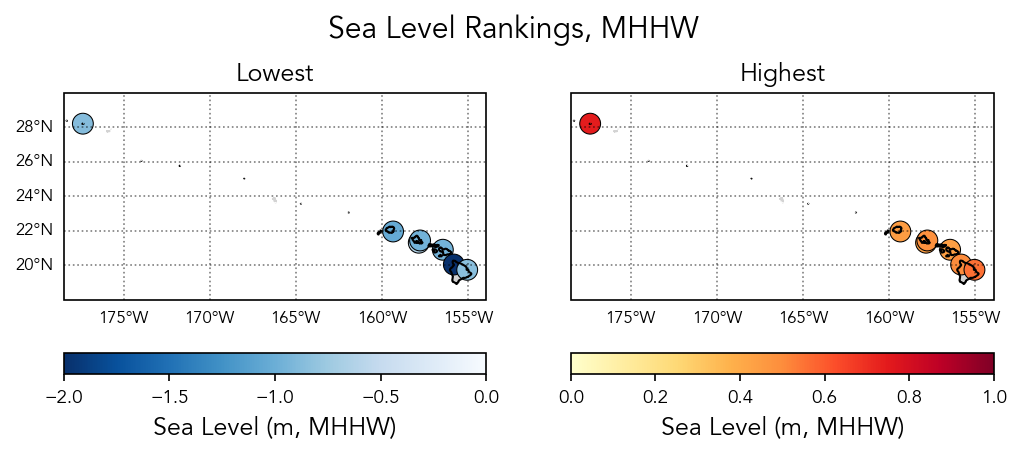

In [15]:
# define vmin and vmax variables
vmin = 0.2
vmax = 0.8

# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc')

xlims = [cmems.longitude.min(), cmems.longitude.max()]
ylims = [cmems.latitude.min(), cmems.latitude.max()]

# get max value for each station
crs = ccrs.PlateCarree()

fig, axs = plt.subplots(1, 2, figsize=(8, 3), 
                        subplot_kw={'projection': ccrs.PlateCarree()})
# make ax,fig


maxplt = axs[1].scatter(max_SL['lon'], max_SL['lat'], transform=crs, s=100, 
           c=max_SL['sea level (m)'], vmin=0, vmax=1, cmap='YlOrRd',
           linewidth=0.5, edgecolor='black')

minplt = axs[0].scatter(min_SL['lon'], min_SL['lat'], transform=crs, s=100, 
           c=min_SL['sea level (m)'], vmin=-2, vmax=0, cmap='Blues_r',
           linewidth=0.5, edgecolor='black')

plt.colorbar(minplt,ax=axs[0],label='Sea Level (m, MHHW)', location='bottom')           
plt.colorbar(maxplt,ax=axs[1],label='Sea Level (m, MHHW)', location='bottom') 


for i, ax in enumerate(axs.flat):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# add title
axs[0].set_title('Lowest')
axs[1].set_title('Highest')

# adjust ylims
axs[0].set_ylim(18,30)
axs[1].set_ylim(18,30)

# super title
fig.suptitle('Sea Level Rankings, MHHW')

#eliminate white space at top
fig.subplots_adjust(top=0.9)

glue("SL_rankings_map",fig,display=False)

# save the figure
figname = 'SL_rankings_map.png'
fig.savefig(output_dir / figname, dpi=300, bbox_inches='tight')

```{glue:figure} SL_rankings_map
:name: "SL_rankings_map"

Lowest and highest observed sea levels, relative to MHHW. 
```

## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```